# Lista 1 Regressão linear, polinomial e regularização

## Sumário

- Questão 1: [A](#Questão-1-a.), [B](#Questão-1-b.), [C](#Questão-1-c.)
- Questão 2: [A](#Questão-2-a.), [B](#Questão-2-b.), [C](#Questão-2-c.), [D](#Questão-2-d.)

<span style="position: absolute; top: 10px; right: 10px; background: green; padding: 0.5em; color: white; border-radius: 8px; font-weight: bold">Vaux Gomes</span>

## Implementações

### Importações

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import \
    BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures

### Métricas

In [2]:
def mse(y, y_hat):
  ''' Mean squared error '''
  return ((y - y_hat)**2).mean()

def rmse(y, y_hat):
  ''' Root mean squared error '''
  return np.sqrt(((y - y_hat)**2).mean())

### Z-score Normalizer

In [3]:
class ZScore():
    ''' Z-score Normalizer '''

    #
    def __init__(self, noise=10**-15):
        self.noise = noise

    #
    def fit_transform(self, X, verbatim=False):
        ''' Z-score normalization '''

        # Dimension
        N = X.shape[0]

        # Mean
        self.mean = X.mean(axis=0)
        
        # Mean difference
        diff = X - self.mean

        # Standard Deviation
        self.std = np.sqrt(1/(N-1) * (diff**2).sum(axis=0))
        
        # Normalized data
        X_ = diff/(self.std + self.noise)
        
        # Data information
        if verbatim:
            print(f'# Noise: {self.noise}')
            print(f'# Data shape: {X.shape} \n')
            print(f'# Data head:\n{X[:5,:]} \n')
            print(f'# Standard deviation:\n{self.std} \n')
            print(f'# Normalized data head:\n{X_[:5,:]} \n')
            
        return X_
    
    #
    def restore(self, X):
        return self.std * X + self.mean

### MinMax Normalizer

In [4]:
class MinMax():
    ''' MinMax Normalizer '''

    #
    def fit_transform(self, X):
        ''' MinMax normalization '''
        #
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        
        #
        return (X - self.min)/(self.max - self.min)
    
    #
    def restore(self, X):
        return X*(self.max - self.min) + self.min

### Ordinary Least Squares

In [5]:
class LinearRegressionOLS(BaseEstimator, RegressorMixin):
    ''' Linear Regression via Ordinary Least Squares (OLS) with Regularization '''

    #
    def __init__(self, noise=10**-5):
        self.noise = noise

    #
    def fit(self, X, y):
        # Auxiliary
        n, m = X.shape

        # Adding a column of ones
        X_ = np.concatenate((np.ones((n,1)), X), axis=1)

        # Regularization
        l2 = np.eye(m+1) * self.noise

        # Calculating ŵ
        self.w_hat = np.linalg.inv((X_.T @ X_) + l2) @ X_.T @ y

    #
    def predict(self, X, y=None):
        # Auxiliary
        N = X.shape[0]

        # Adding a column of ones
        X_ = np.concatenate((np.ones((N,1)), X), axis=1)

        # Predictions
        return X_ @ self.w_hat
    
    #
    def __str__(self):
        return f'Ordinary Least Squares: {np.squeeze(self.w_hat)}'

### Gradient Decent

In [6]:
class LinearRegressionGD(BaseEstimator, RegressorMixin):
    ''' Linear Regression via Gradient Descent (GD) '''

    #
    def __init__(self, alpha=10**-3, max_iter=10**5):
        self.max_iter = max_iter
        self.alpha = alpha

    #
    def fit(self, X, y):
        # Cleaning
        self.costs = []

        # Auxiliary
        _, m = X.shape

        # Initial weights
        self.w = np.zeros(2) # y-intercept (b), slope (a)
               
        # Initial error
        self.costs.append(mse(y, self.predict(X)))

        # Main loop
        for i in range(self.max_iter):
            # Step (ax + b)
            ew0 = (y - (self.w[0] + self.w[1]*X)).sum()
            ew1 = ((y - (self.w[0] + self.w[1]*X))*X).sum()
            
            # Update
            self.w[0] += self.alpha * ew0
            self.w[1] += self.alpha * ew1
            
            # Appending error
            self.costs.append(mse(y, self.predict(X)))
            
            # Stopping iterating
            a, b = self.costs[-2:]
            if (np.isclose(a, b)):
                print(f'Ended at iteration {i}')
                return
         
    #
    def predict(self, X, y=None):
        return self.w[0] + self.w[1]*X
    
    #
    def __str__(self):
        return f'Linear Regression via Gradient Descent: {self.w}'

### Stochastic Gradient Decent

In [7]:
# https://en.wikipedia.org/wiki/Stochastic_gradient_descent

class LinearRegressionSGD(BaseEstimator, RegressorMixin):
    ''' Linear Regression via Stochastic Gradient Descent (SGD) '''

    #
    def __init__(self, alpha=10**-3, max_iter=10**5):
        self.max_iter = max_iter
        self.alpha = alpha

    #
    def fit(self, X, y):
        # Cleaning
        self.costs = []

        # Auxiliary
        n, m = X.shape

        # Initial weights
        self.w = np.zeros(2) # y-intercept (b), slope (a)
               
        # Initial error
        self.costs.append(mse(y, self.predict(X)))
        
        # Indexes
        idx = list(range(n))

        # Main loop
        for i in range(self.max_iter):
            # Everyday I'm Shuffling
            np.random.shuffle(idx)
            
            for j in idx:
                # Step (ax + b)
                ew0 = (y[j] - (self.w[0] + self.w[1]*X[j])).sum()
                ew1 = ((y[j] - (self.w[0] + self.w[1]*X[j]))*X[j]).sum()
            
                # Update
                self.w[0] += self.alpha * ew0
                self.w[1] += self.alpha * ew1
            
                # Appending error
                self.costs.append(mse(y, self.predict(X)))

            # err = self.costs[-1]
         
    #
    def predict(self, X, y=None):
        return self.w[0] + self.w[1]*X
    
    #
    def __str__(self):
        return f'Linear Regression via Stochastic Gradient Descent: {self.w}'

---

## Questão 1

Considere o conjunto de dados disponível em `artificial1d.csv` organizado em
duas colunas, $x$ e $y$. Seja um modelo de regressão linear para $\hat{y} = f(x)$.

In [8]:
# Importação dos conjuntos de dados
artificial = np.genfromtxt('artificial1d.csv', delimiter=',')
california = np.genfromtxt('california.csv', delimiter=',')

print(f'Artificial: {artificial.shape}')
print(f'Califórnia: {california.shape}')

Artificial: (30, 2)
Califórnia: (1000, 9)


### Questão 1 a.

Apresente os <u>parâmetros do modelo</u> e o <u>MSE</u> (erro quadrático médio) obtidos pelo algoritmo <big><strong>OLS (mínimos quadrados ordinários)</strong></big>. Plote a reta resultante sobre os dados.

[Início ↑](#Sumário)

In [9]:
# Normalização dos dados
normalizer = ZScore()
artificial_norm = normalizer.fit_transform(artificial)

# Separando variáveis independentes e dependente
X = artificial_norm[:, :-1]
y = artificial_norm[:, -1:]

In [10]:
# Treinamento
model = LinearRegressionOLS()
model.fit(X, y)

print(model)

# Predição
y_hat = model.predict(X)

# Erro de treinamento
print(f'MSE: {mse(y, y_hat):.7}')

Ordinary Least Squares: [0.        0.8974936]
MSE: 0.1880212


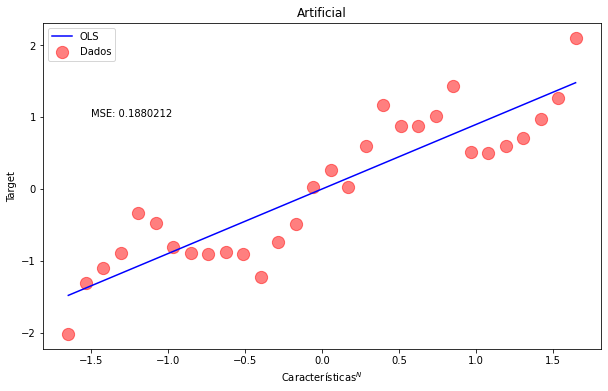

In [11]:
# Plot
plt.figure(figsize=(10, 6))

#
plt.plot(X, y_hat, color='b', label="OLS")
plt.scatter(np.squeeze(X), y, color='r', s=[150], alpha=0.5, label="Dados")

#
plt.title("Artificial")
plt.xlabel("Características$^N$")
plt.ylabel("Target")

#
plt.text(-1.5, 1, f'MSE: {mse(y, y_hat):.7}')

#
plt.legend(loc="upper left")
plt.show()

### Questão 1 b.
#### Gradient Descent
Apresente os <u>parâmetros do modelo</u>, o <u>MSE</u> e a <u>curva de aprendizagem</u> obtidos pelo algoritmo <big><strong>GD (gradiente descendente)</strong></big>. Plote a reta resultante sobre os dados.

> **Nota**: Os valores de $X$ e $y$ foram definidos na questão anterior

[Início ↑](#Sumário)

In [12]:
# Treinamento
model = LinearRegressionGD(max_iter=200)
model.fit(X, y)

print(model)

# Predição
y_hat = model.predict(X)

# Erro de treinamento
print(f'MSE: {mse(y, y_hat):.7}')

Ended at iteration 172
Linear Regression via Gradient Descent: [2.84217094e-17 8.91973663e-01]
MSE: 0.1880507


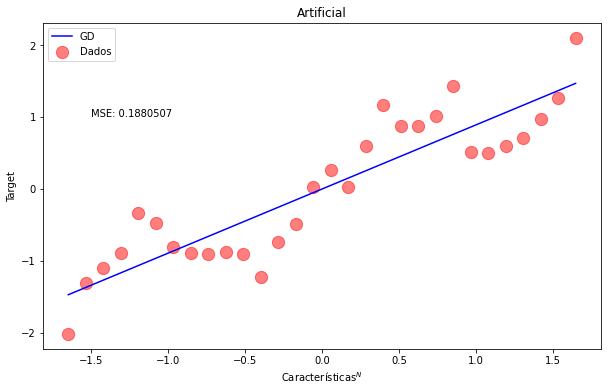

In [13]:
# Plot
plt.figure(figsize=(10, 6))

#
plt.plot(X, y_hat, color='b', label="GD")
plt.scatter(np.squeeze(X), y, color='r', s=[150], alpha=0.5, label="Dados")

#
plt.title("Artificial")
plt.xlabel("Características$^N$")
plt.ylabel("Target")

#
plt.text(-1.5, 1, f'MSE: {mse(y, y_hat):.7}')

#
plt.legend(loc="upper left")
plt.show()

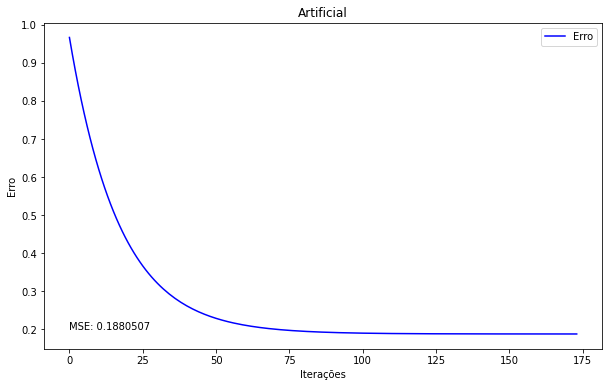

In [14]:
# Plot: Erro
plt.figure(figsize=(10, 6))

#
plt.plot(model.costs, color='b', lw=1.5, label="Erro")

#
plt.title("Artificial")
plt.xlabel("Iterações")
plt.ylabel("Erro")

#
plt.text(0, 0.2, f'MSE: {mse(y, y_hat):.7}')

#
plt.legend(loc="upper right")
plt.show()

### Questão 1 c.
Apresente os <u>parâmetros do modelo</u>, o <u>MSE</u> e a <u>curva de aprendizagem</u>
obtidos pelo algoritmo <big><strong>SGD (gradiente descendente estocástico)</strong></big>. Plote a reta resultante sobre os dados.

> **Nota**: Os valores de $X$ e $y$ foram definidos anteriormente

[Início ↑](#Sumário)

In [15]:
# Treinamento
model = LinearRegressionSGD(max_iter=100)
model.fit(X, y)

print(model)

# Predição
y_hat = model.predict(X)

# Erro de treinamento
print(f'MSE: {mse(y, y_hat):.7}')

Linear Regression via Stochastic Gradient Descent: [-6.67485852e-05  8.48308170e-01]
MSE: 0.1903598


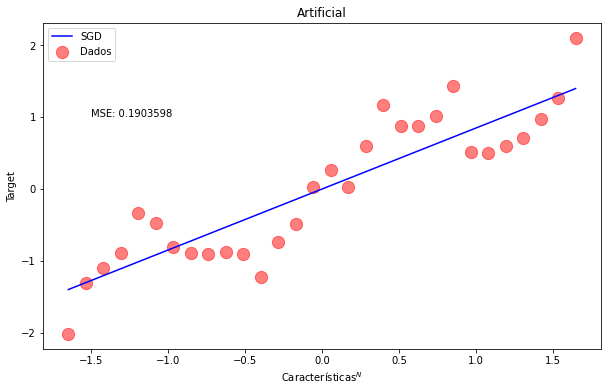

In [16]:
# Plot
plt.figure(figsize=(10, 6))

#
plt.plot(X, y_hat, color='b', label="SGD")
plt.scatter(np.squeeze(X), y, color='r', s=[150], alpha=0.5, label="Dados")

#
plt.title("Artificial")
plt.xlabel("Características$^N$")
plt.ylabel("Target")

#
plt.text(-1.5, 1, f'MSE: {mse(y, y_hat):.7}')

#
plt.legend(loc="upper left")
plt.show()

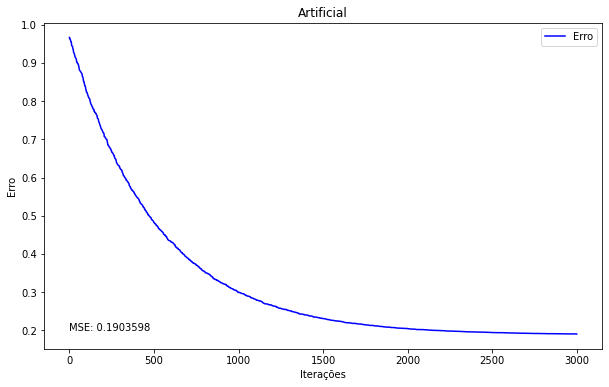

In [17]:
# Plot: Erro
plt.figure(figsize=(10, 6))

#
plt.plot(model.costs, color='b', lw=1.5, label="Erro")

#
plt.title("Artificial")
plt.xlabel("Iterações")
plt.ylabel("Erro")

#
plt.text(0, 0.2, f'MSE: {mse(y, y_hat):.7}')

#
plt.legend(loc="upper right")
plt.show()

---

## Questão 2

Considere o conjunto de dados disponível em `california.csv`, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição da mediana de preços de casas em distritos da Califórnia na década de 1990.

> Os dados já foram carregados

In [18]:
# Normalização dos dados
normalizer = MinMax()
california_norm = normalizer.fit_transform(california)

# Separando variáveis independentes e dependente
X = california_norm[:, :-1]
y = california_norm[:, -1:]

### Questão 2 a.

Aleatoriamente, divida o conjunto de dados em treino (80%) e teste (20%).

[Início ↑](#Sumário)

In [19]:
# Split
split = int(0.8 * X.shape[0])

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### Questão 2 b.

Treine 13 modelos de <big><strong>regressão polinomial</strong></big>, com ordens de 1 a 13. Você <u>pode usar o algoritmo OLS</u>.

> Fiz apenas até a ordem 8

[Início ↑](#Sumário)

In [20]:
# Erros
err_train = []
err_test = []

# Modelo
model = LinearRegressionOLS()

for i in range(8):
    # Gerando novas features
    poly = PolynomialFeatures(i + 1)
    
    #
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Treinamento
    model.fit(X_train_poly, y_train)

    # Predição
    y_train_hat = model.predict(X_train_poly)
    y_test_hat = model.predict(X_test_poly)
    
    # Erros
    err_train.append(rmse(y_train, y_train_hat))
    err_test.append(rmse(y_test, y_test_hat))
    
    print(f'Order {i + 1}', end=', ')

Order 1, Order 2, Order 3, Order 4, Order 5, Order 6, Order 7, Order 8, 

### Questão 2 c.

Reporte o RMSE (raiz quadrada do erro quadrático médio) no treinamento e no teste para cada modelo. Faça um gráfico para o treino e um gráfico para o teste.

[Início ↑](#Sumário)

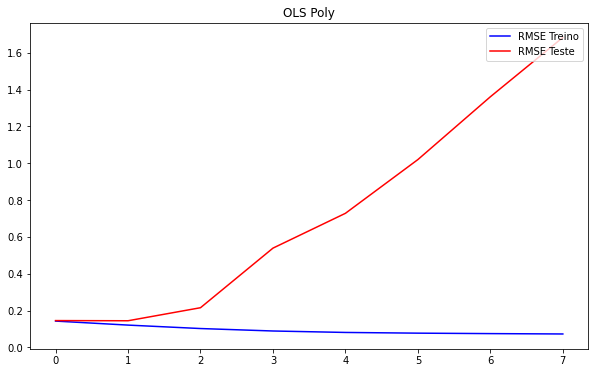

In [21]:
# Plot: Erro
plt.figure(figsize=(10, 6))

#
plt.plot(err_train, color='b', lw=1.5, label="RMSE Treino")
plt.plot(err_test, color='r', lw=1.5, label="RMSE Teste")

#
plt.title("OLS Poly")

#
plt.legend(loc="upper right")
plt.show()

### Questão 2 d.

Repita os 2 itens anteriores incluindo um termo de regularização L2 (por exemplo, com fator λ = 0.01).

> Fiz apenas até a ordem 8 também

[Início ↑](#Sumário)

In [ ]:
# Erros
err_train_l2 = []
err_test_l2 = []

# Modelo
model = LinearRegressionOLS(noise=0.01)

for i in range(8):
    # Gerando novas features
    poly = PolynomialFeatures(i + 1)
    
    #
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Treinamento
    model.fit(X_train_poly, y_train)

    # Predição
    y_train_hat = model.predict(X_train_poly)
    y_test_hat = model.predict(X_test_poly)
    
    # Erros
    err_train_l2.append(rmse(y_train, y_train_hat))
    err_test_l2.append(rmse(y_test, y_test_hat))
    
    print(f'Order {i + 1}', end=', ')

Order 1, Order 2, Order 3, Order 4, Order 5, Order 6, Order 7, 

In [ ]:
# Plot: Erro
plt.figure(figsize=(10, 6))

#
plt.plot(err_train_l2, color='b', lw=1.5, label="RMSE Treino")
plt.plot(err_test_l2, color='r', lw=1.5, label="RMSE Teste")

#
plt.title("OLS Poly L2")

#
plt.legend(loc="upper right")
plt.show()